In [71]:

import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
import sklearn.pipeline
%matplotlib inline


Read in the Data 

In [72]:
data = pd.read_csv("breast-cancer.csv")
data = data.drop("id", axis = 1)
data = data.replace({"M","B"},{1,0})
data = data.sample(frac=1, random_state=1)
Y = data["diagnosis"]
X = data.drop("diagnosis",axis = 1)
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
421,14.69,13.98,98.22,656.1,0.10310,0.18360,0.14500,0.06300,0.2086,0.07406,...,16.46,18.34,114.10,809.2,0.1312,0.36350,0.3219,0.11080,0.2827,0.09208
47,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,0.06777,...,15.67,27.95,102.80,759.4,0.1786,0.41660,0.5006,0.20880,0.3900,0.11790
292,12.95,16.02,83.14,513.7,0.10050,0.07943,0.06155,0.03370,0.1730,0.06470,...,13.74,19.93,88.81,585.4,0.1483,0.20680,0.2241,0.10560,0.3380,0.09584
186,18.31,18.58,118.60,1041.0,0.08588,0.08468,0.08169,0.05814,0.1621,0.05425,...,21.31,26.36,139.20,1410.0,0.1234,0.24450,0.3538,0.15710,0.3206,0.06938
414,15.13,29.81,96.71,719.5,0.08320,0.04605,0.04686,0.02739,0.1852,0.05294,...,17.26,36.91,110.10,931.4,0.1148,0.09866,0.1547,0.06575,0.3233,0.06165


# Data Exploration

The data set we collected was made for classifying breast tumors as either malignant or benign. The data was already well cleaned and maintained, there were no NULL values reported as NAN as seen below and the few values of 0 were in features that had a large distribution close to zero and where a value of 0 made since (concavity would be 0 if it wasn't concave). The data was parsed into 30 summary features comprising the mean, standard error, and worst case value for a number of different measurements. To initially prepare the data we changed M and B to 1 and 0, 1 being Malignant and 0 being Benign, removed the id and split the label from the features.

In [73]:
# check for null values 
data.isnull().sum().sum()

0

In order to determine what data features were useful in classifying a record we used a method that calculated the mutual information between a feature and the resulting label. Mutual Information is a measure of the dependence two variables have with one another with a value of 0 being total independence. We ran the models both with a cut-off mutual information value of 0.1 and 0.7, which resulting in data sets of around 20 features and 24 features respectively. While the dataset with a cutoff of 0.1 had a higher average mutual information value across the whole data set, being around 0.32, as compared to the data with a cutoff of 0.7, which had a value of around 0.26. Both of these being a significant improvement over the initial Mutual Information value of 0.21. 

Despite the higher Mutual Information value however, the model with the lower cutoff actually resulted in slightly better results, likely because with our extremely small dataset removing too many columns had small but notable impact on our accuracy. Therefore we utilized a final cutoff of 0.7 which provided the best final output.
 
Note: these exact values may vary with the exact values chosen from random state so I set one value for consistency

In [74]:
from sklearn import feature_selection

keep_list = []

# Select which features to keep
for index in range(X.shape[1]):
    if(feature_selection.mutual_info_classif(pd.DataFrame(X.iloc[:,index]),Y,random_state=70) >= 0.1):
       keep_list.append(X.columns[index])
X_reduced_1 = X[keep_list]

keep_list = []
for index in range(X.shape[1]):
    if(feature_selection.mutual_info_classif(pd.DataFrame(X.iloc[:,index]),Y, random_state=70) >= 0.07):
       keep_list.append(X.columns[index])


X_reduced = X[keep_list]

print("Initial Mutual Information across dataset:",np.average(feature_selection.mutual_info_classif(X,Y,random_state=70)) )
print("Mutual Information with cutoff at 0.1:",np.average(feature_selection.mutual_info_classif(X_reduced_1,Y,random_state=70)))
print("Mutual Information with cutoff at 0.07:",np.average(feature_selection.mutual_info_classif(X_reduced,Y,random_state=70)),)


print("List of features kept:")
for index in range(len(keep_list)):
    print(index, ") ", '\t',  keep_list[index])

X = X_reduced

print(X_reduced.shape)

Initial Mutual Information across dataset: 0.21326031412580918
Mutual Information with cutoff at 0.1: 0.3201697922377496
Mutual Information with cutoff at 0.07: 0.2609277587011573
List of features kept:
0 )  	 radius_mean
1 )  	 texture_mean
2 )  	 perimeter_mean
3 )  	 area_mean
4 )  	 smoothness_mean
5 )  	 compactness_mean
6 )  	 concavity_mean
7 )  	 concave points_mean
8 )  	 symmetry_mean
9 )  	 radius_se
10 )  	 perimeter_se
11 )  	 area_se
12 )  	 compactness_se
13 )  	 concavity_se
14 )  	 concave points_se
15 )  	 radius_worst
16 )  	 texture_worst
17 )  	 perimeter_worst
18 )  	 area_worst
19 )  	 smoothness_worst
20 )  	 compactness_worst
21 )  	 concavity_worst
22 )  	 concave points_worst
23 )  	 symmetry_worst
(569, 24)


Best K-Nearest Neighbor: 3.25


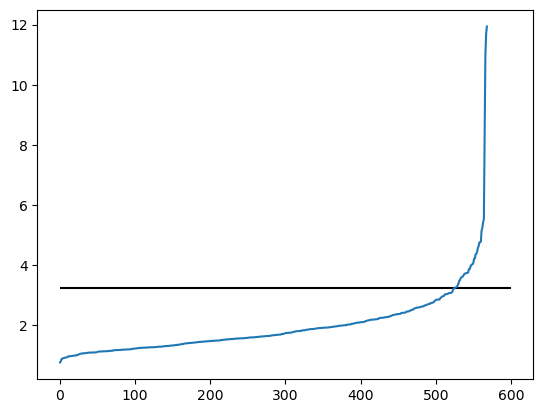

In [75]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
scaler = StandardScaler()
pca = PCA(n_components=0.95, svd_solver="full")
# scales and reduces dimension of data to improve distance based models
processed_data = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X)))
nn = NearestNeighbors(n_neighbors=4)
nn.fit(processed_data)
distance_matrix = nn.kneighbors(processed_data)[0]
distances = np.sort(distance_matrix[:,3])
print("Best K-Nearest Neighbor: 3.25")
plt.plot(distances)
plt.hlines(y=3.25, xmin=0, xmax=600)
# best eps around 2.5 for a cutoff on mutual info of .1
plt.show()

Estimated no. of clusters: 2
Estimated no. of noise points: 24


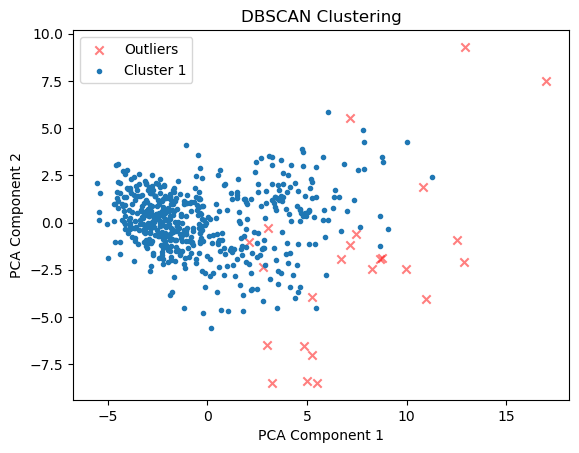

In [76]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=3.25, min_samples=4).fit(processed_data)
labels = db.labels_
no_clusters = len(np.unique(labels))
no_noise = np.sum(np.array(labels) == -1, axis=0)
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

inliersX = X.loc[labels == 0]
outliersX = X.loc[labels == -1]

inliersY = Y.loc[labels == 0]
outliersY = Y.loc[labels == -1]


plt.scatter(processed_data.loc[labels == -1, 0], processed_data.loc[labels == -1, 1], 
                    c='red', marker='x', label='Outliers', alpha=0.5)
plt.scatter(processed_data.loc[labels == 0, 0], processed_data.loc[labels == 0, 1], 
                    marker='.', label=f'Cluster 1')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clustering')
plt.legend()
plt.show()


K means clustering accuracy when including outliers 0.9244288224956063
K means clustering accuracy when excluding outliers 0.9376146788990826


/u/ajimenea/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/u/ajimenea/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


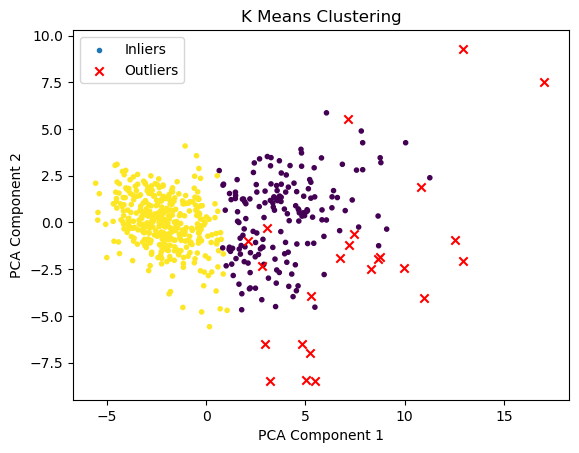

In [77]:
from sklearn.cluster import KMeans

inliers = processed_data[labels == 0]
outliers = processed_data[labels == -1]

# Perform KMeans clustering on the original scaled data
kmeans = KMeans(n_clusters=2, random_state=42)

kmeans.fit(processed_data)
klabels_with_outliers = kmeans.labels_
kmeans.fit(inliers)
klabels = kmeans.labels_

k_means_accuracy = max((inliersY == klabels).sum()/(inliersY == klabels).count(), 
                            (inliersY == klabels^1).sum()/(inliersY == klabels^1).count())
k_means_accuracy_wo = max((Y == klabels_with_outliers^1).sum()/(Y == klabels_with_outliers^1).count(),
                            (Y == klabels_with_outliers).sum()/(Y == klabels_with_outliers).count())


print("K means clustering accuracy when including outliers",k_means_accuracy_wo)
print("K means clustering accuracy when excluding outliers",k_means_accuracy)


plt.scatter(inliers.iloc[:,0], inliers.iloc[:,1], c=klabels,marker='.', label='Inliers')
plt.scatter(outliers.iloc[:,0], outliers.iloc[:,1], c='red', marker='x', label='Outliers')
plt.legend()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K Means Clustering')
plt.legend()
plt.show()


# Metric Calculation

The following code is utility code that we use to get the metrics for our data. In here, we get calculations (accuracy, recall, precision), generate confusion matrices, and print out our formated metrics. 

In [78]:

X = inliersX
Y = inliersY

# Print statement for metrics at the end

from sklearn import metrics

# Using the code for calculating and printing 
# the confusion matrix from Assignment 3
def get_confusion(test_data, results):
    TN = 0
    TP = 0
    FN = 0
    FP = 0
    for i in range(len(test_data)):
        expected = test_data[i]
        if(expected):
            if (results[i]):
                TP += 1
            else:
                FN += 1
        else:
            if (results[i]): #is neg guessed pos
                FP += 1
            else: 
                TN += 1



    return TN, TP, FN, FP 

def print_confusion_matrix(TP, FN, FP, TN):
    
    table_data = [[TP,FN],[FP,TN]]
    df = pd.DataFrame(table_data, columns =['Predicted 1','Predicted 0'])
    df = df.rename(index={0: 'Actual 1', 1: 'Actual 0'})
    display(df)

# takes in a list of predicted values and test sets for each fold of crossvalidation
def PrintMetrics_list(y_actual, y_pred):
    accuracies = []
    tn = 0
    tp = 0
    fn = 0
    fp = 0
    loops = len(y_pred)
    for i in range(loops):
        accuracies.append(sk.metrics.accuracy_score(y_actual[i],y_pred[i]))
        confusion = get_confusion(list(y_actual[i]),list(y_pred[i]))
        tn += confusion[0]
        tp += confusion[1]
        fn += confusion[2]
        fp += confusion[3]
    accuracy = np.average(accuracies)
    print("\tAccuracy:",accuracy)
    print_confusion_matrix(tp,fn,fp,tn)
    precision = tp/(tp+fp)
    recall = tp/(tp + fn)
    print("\tPrecision: ",precision)
    print("\tRecall:",recall)

def PrintMetrics(y_actual, y_pred):
    tn = 0
    tp = 0
    fn = 0
    fp = 0
    accuracy = sk.metrics.accuracy_score(y_actual,y_pred)
    confusion = get_confusion(y_actual,y_pred)
    tn += confusion[0]
    tp += confusion[1]
    fn += confusion[2]
    fp += confusion[3]
    
    print("Accuracy:",accuracy)
    print_confusion_matrix(tp,fn,fp,tn)
    precision = tp/(tp+fp)
    recall = tp/(tp + fn)
    print("Precision: ",precision)
    print("Recall:",recall)
    



# Models


## Random forest
For this model, we experimented with hyperparameters max_depth and min_samples_leaf. The max_depth parameter determines the max depth of the tree, and the min_sample_leaf sets the minimin number of samples present in order for a node to be considered as a leaf.

When examining the max_depth, we discovered that a value of around 32 was chosen the most. When examining the min_samples_leaf, we found out GridSearchCV always prefer the sample to be the lowest value in the range. 

The final results from this model are: \
**Accuracy**: 0.9722222222222221 \
            Predicted 1	Predicted 0 \
Actual 1	345	5 \
Actual 0	10	180 \
**Precision**:  0.971830985915493 \
**Recall**: 0.9857142857142858 


In [79]:
outputs = []

#Random Forest
print("Testing Random Forest...\n")
from sklearn import model_selection
from sklearn import ensemble

# Hyperparameters: 
param_grid = { 
    "max_depth": list(range(30,40)),
    "min_samples_leaf": list(range(1,3,2))
}

inner = sk.model_selection.GridSearchCV(sk.ensemble.RandomForestClassifier(),param_grid)
kf = sk.model_selection.KFold(n_splits=5)

actuals = []
preds = []

# 5 fold cross validation 
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print("Iteration ", i)
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    # Run Random Forest
    inner.fit(X_train,Y_train)
    print("\tChosen max_depth:",inner.best_estimator_.get_params()["max_depth"])
    print("\tChosen min_samples_leaf:",inner.best_estimator_.get_params()["min_samples_leaf"])
    print()
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)

# Appending to output list
outputs.append(["Random Forest",actuals,preds])

Testing Random Forest...

Iteration  0


	Chosen max_depth: 37
	Chosen min_samples_leaf: 1

Iteration  1
	Chosen max_depth: 37
	Chosen min_samples_leaf: 1

Iteration  2
	Chosen max_depth: 38
	Chosen min_samples_leaf: 1

Iteration  3
	Chosen max_depth: 30
	Chosen min_samples_leaf: 1

Iteration  4
	Chosen max_depth: 30
	Chosen min_samples_leaf: 1



## ADA Boosting
For this model we use the ADA Boost Classifier with the parameter n_estimators equal to 100, 110, 120, 130, or 140. \
The n_estimators hyperparameter sets the maximum number of estimators at which boosting is terminated. 

The final results from this model are: 

**Accuracy**: 0.9740740740740741 \
Predicted 1	Predicted 0 \
Actual 1	346	4 \
Actual 0	10	180 \
**Precision**:  0.9719101123595506 \
**Recall**: 0.9885714285714285


In [80]:
#ADA Boosting
print("Testing ADA Boosting...\n")

# Hyperparameters
param_grid = { 
   'n_estimators': list(range(100,150,10)),
}

boost = sk.ensemble.AdaBoostClassifier(algorithm="SAMME")
inner = sk.model_selection.GridSearchCV(boost,param_grid,cv= 5)

preds = []
actuals = []

# 5 fold cross validation 
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print("Iteration", i)
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    # Run ADA boost
    inner.fit(X_train,Y_train)
    print("\tChosen n_estimators:",inner.best_estimator_.get_params()["n_estimators"])
    print()
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)

# Appending to output list
outputs.append(["ADA Boosting",actuals,preds])

Testing ADA Boosting...

Iteration 0
	Chosen n_estimators: 110

Iteration 1
	Chosen n_estimators: 140

Iteration 2
	Chosen n_estimators: 100

Iteration 3
	Chosen n_estimators: 100

Iteration 4
	Chosen n_estimators: 110



## SVM
For this model we use the SVM Classifier with the parameter pca__n_components equal to a value from 5-15 and svc_kernal either linear or rbf. \
The pca_n_components hyperparameter limits the number of components to keep, and the svc_kernal hyperparameter specifies the kernel type to be used in the model.

The final results from this model are: 

**Accuracy**:  0.9796296296296296 \
Predicted 1	Predicted 0 \
Actual 1	348	2 \
Actual 0	9	181 \
**Precision**: 0.9747899159663865 \
**Recall**: 0.9942857142857143

In [81]:
#SVM
print("Testing SVM...\n")

scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
svc = sk.svm.SVC()
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("pca",pca),("svc",svc)])

# Hyperparameters
param_grid = { 
    'pca__n_components': list(range(5, 15)),
    'svc__kernel': ["linear","rbf"]
}

inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv=5)

preds = []
actuals = []

# 5 fold cross validation
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print("Iteration", i)
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    # Run SVM
    inner.fit(X_train,Y_train)
    print("\tChosen n_components:",inner.best_estimator_.get_params()["pca__n_components"])
    print("\tChosen kernel:",inner.best_estimator_.get_params()["svc__kernel"])
    print()
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)

# Appending to output list
outputs.append(["SVM",actuals,preds])


Testing SVM...

Iteration 0
	Chosen n_components: 9
	Chosen kernel: linear

Iteration 1
	Chosen n_components: 12
	Chosen kernel: linear

Iteration 2
	Chosen n_components: 10
	Chosen kernel: linear

Iteration 3
	Chosen n_components: 9
	Chosen kernel: linear

Iteration 4
	Chosen n_components: 13
	Chosen kernel: linear



## Nearest Neighbor
For this model we use the K-Nearest Neighbor Classifier with the parameter pca_n_components equal to a value between 5-10 and knn__n_neighbors equal to a value from 2-4. \
The pca_n_components hyperparameter limits the number of components to keep, and the knn__n_neighbors sets the number of neighbors to use.

The final results from this model are: 

**Accuracy**:  0.9666666666666666 \
Predicted 1	Predicted 0 \
Actual 1	345	5 \
Actual 0	13	177 \
**Precision**:  0.9636871508379888 \
**Recall**: 0.9857142857142858

In [82]:
#Nearest Neighbor
print("Testing K-Nearest Neighbors...\n")

scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
knn = sk.neighbors.KNeighborsClassifier()
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("pca",pca),("knn",knn)])

# Hyperparameters
param_grid = {
    'pca__n_components': list(range(5,10)),
    'knn__n_neighbors': list(range(2,4))
}

inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv = 5)

preds = []
actuals = []

# 5 fold cross validation
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print("Iteration",i)
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    # Run nearest neighbor
    inner.fit(X_train,Y_train)
    print("\tChosen n_components:",inner.best_estimator_.get_params()["pca__n_components"])
    print("\tChosen n_neighbors:",inner.best_estimator_.get_params()["knn__n_neighbors"])
    print()
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)

# Appending to output list
outputs.append(["K Nearest Neighbor",actuals,preds])


Testing K-Nearest Neighbors...

Iteration 0
	Chosen n_components: 9
	Chosen n_neighbors: 3

Iteration 1
	Chosen n_components: 9
	Chosen n_neighbors: 3

Iteration 2
	Chosen n_components: 7
	Chosen n_neighbors: 3

Iteration 3
	Chosen n_components: 9
	Chosen n_neighbors: 3

Iteration 4
	Chosen n_components: 7
	Chosen n_neighbors: 3



## Simple Neural Net
For this model we use a simple Neural Net Classifier with the parameter nn__hidden_layer_sizes equal to 30, 40, 50, or 60,  nn__activation equal to a tanh, and nn__max_iter equal to 200, 250, 300, 350, or 400. \
The nn__hidden_layer_sizes is the number of neurons in the ith hidden layer. The nn__activation is the activation function for the hidden layer. When we experimented with different functions, ther algorithm always picked the tanh function. The nn__max_iter parameter sets the maximum number of iterations.

The final results from this model are: 

**Accuracy**:  0.975925925925926\
Predicted 1	Predicted 0 \
Actual 1	346	4 \
Actual 0	9	181 \
**Precision**:  0.9746478873239437 \
**Recall**: 0.9885714285714285

In [83]:
#Simple Neural Net
print("Testing Simple Neural Nets...\n")
from sklearn import neural_network

scaler = sk.preprocessing.StandardScaler()
nn = sk.neural_network.MLPClassifier(learning_rate="invscaling",learning_rate_init=0.1)
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("nn",nn)])

# Hyperparameters
param_grid = { 
    "nn__hidden_layer_sizes": [(30,),(40,),(50,),(60,)],
    "nn__activation": ["tanh",],
    "nn__max_iter" : [200,250,300,350,400]
}

inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv=5)

preds = []
actuals = []

# 5 fold cross validation
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    # Run neural net
    inner.fit(X_train,Y_train)
    print("Iteration", i)
    print("\tChosen hidden_layer_sizes:",inner.best_estimator_.get_params()["nn__hidden_layer_sizes"])
    print("\tChosen activation:",inner.best_estimator_.get_params()["nn__activation"])
    print("\tChosen max_iter:",inner.best_estimator_.get_params()["nn__max_iter"])
    print()
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)

# Appending to output list
outputs.append(["Neural Nets",actuals,preds])



Testing Simple Neural Nets...

Iteration 0
	Chosen hidden_layer_sizes: (60,)
	Chosen activation: tanh
	Chosen max_iter: 250

Iteration 1
	Chosen hidden_layer_sizes: (40,)
	Chosen activation: tanh
	Chosen max_iter: 250

Iteration 2
	Chosen hidden_layer_sizes: (50,)
	Chosen activation: tanh
	Chosen max_iter: 300

Iteration 3
	Chosen hidden_layer_sizes: (30,)
	Chosen activation: tanh
	Chosen max_iter: 250

Iteration 4
	Chosen hidden_layer_sizes: (30,)
	Chosen activation: tanh
	Chosen max_iter: 250



In [84]:
for output in outputs:
    print("Metrics for",output[0])
    print()
    PrintMetrics_list(output[1],output[2])
    print('\n')

Metrics for Random Forest

	Accuracy: 0.9541284403669724


,Predicted 1,Predicted 0
Actual 1,342,11
Actual 0,14,178


	Precision:  0.9606741573033708
	Recall: 0.9688385269121813


Metrics for ADA Boosting

	Accuracy: 0.9706422018348624


,Predicted 1,Predicted 0
Actual 1,350,3
Actual 0,13,179


	Precision:  0.9641873278236914
	Recall: 0.9915014164305949


Metrics for SVM

	Accuracy: 0.9798165137614679


,Predicted 1,Predicted 0
Actual 1,349,4
Actual 0,7,185


	Precision:  0.9803370786516854
	Recall: 0.9886685552407932


Metrics for K Nearest Neighbor

	Accuracy: 0.9688073394495413


,Predicted 1,Predicted 0
Actual 1,348,5
Actual 0,12,180


	Precision:  0.9666666666666667
	Recall: 0.9858356940509915


Metrics for Neural Nets

	Accuracy: 0.9798165137614678


,Predicted 1,Predicted 0
Actual 1,348,5
Actual 0,6,186


	Precision:  0.9830508474576272
	Recall: 0.9858356940509915




# Results

We found the best model for our data to be SVM as it has both a higher accuracy and recall. Our models in order from best to worst are: 1) SVM, 2) Neural Nets, 3) K Nearest Neighbor, 4) ADA Boosting, 5) Random Forests.